<a href="https://colab.research.google.com/github/Jayden-Nyamiaka/Machine-Learning-and-Data-Mining/blob/main/nyamiaka_jayden_prob4_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4

Use this notebook to write your code for problem 4.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 3D - Convolutional network

As in problem 3, we have conveniently provided for your use code that loads and preprocesses the MNIST data.

In [ ]:
# load MNIST data into PyTorch format
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(0)

# set batch size
batch_size = 32

# load training data downloaded into data/ folder
mnist_training_data = torchvision.datasets.MNIST('data/', train=True, download=True,
                                                transform=transforms.ToTensor())
# transforms.ToTensor() converts batch of images to 4-D tensor and normalizes 0-255 to 0-1.0
training_data_loader = torch.utils.data.DataLoader(mnist_training_data,
                                                  batch_size=batch_size,
                                                  shuffle=True)

# load test data
mnist_test_data = torchvision.datasets.MNIST('data/', train=False, download=True,
                                                transform=transforms.ToTensor())
test_data_loader = torch.utils.data.DataLoader(mnist_test_data,
                                                  batch_size=batch_size,
                                                  shuffle=False)

In [ ]:
# look at the number of batches per epoch for training and validation
print(f'{len(training_data_loader)} training batches')
print(f'{len(training_data_loader) * batch_size} training samples')
print(f'{len(test_data_loader)} validation batches')

1875 training batches
60000 training samples
313 validation batches


In [ ]:
# sample model
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.75),
    
    nn.Conv2d(8, 8, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.75),
    
    nn.Flatten(),
    nn.Linear(25*8, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

In [ ]:
# why don't we take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)

torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([64, 200])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [ ]:
# our model has some # of parameters:
count = 0
trainable_count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
    if p.requires_grad:
        trainable_count += n_params
print(f'total params: {count}\ntrainable params: {trainable_count}')

total params: 14178
trainable params: 14178


In [ ]:
# For a multi-class classification problem
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

# Visualization

We are providing you with a function to help you visualize what your model is learning.

Your model takes in an image as input and outputs a vector in 10-dimensional space. If your model is a good digit classifier, then you would expect that output vectors corresponding to the same digit should be close together in this 10-dimensional space. If it achieves that, then we say it learned a useful representation of the digits - your model is capable of encoding incredibly high-dimensional data (raw-pixels of an image) into a more compact 10-dimensional space.

While we cannot directly visualize a high-dimensional space, we can project these vectors into 2 dimensions to get a sense of what is going on. We do this using an algorithm called tSNE.

In [ ]:
from sklearn.manifold import TSNE

def visualize_predictions(model):
    #  TSNE projects high-dimensional vectors to 2D space
    tsne = TSNE(n_components=2, learning_rate="auto", init="random")

    sample_size = 1000
    data_sampler = torch.utils.data.DataLoader(mnist_training_data, batch_size=sample_size, shuffle=True)
    sample = next(iter(data_sampler))
    images, labels = sample
    feature_vectors = model(images)
    features_2D = tsne.fit_transform(feature_vectors.detach().numpy())

    for digit in range(0, 10):
        points_x, points_y = [], []
        for i in range(len(features_2D)):
            if labels[i].item() == digit:
                points_x.append(features_2D[i, 0])
                points_y.append(features_2D[i, 1])
        plt.scatter(points_x, points_y, label=f"{digit}")

    plt.legend()
    plt.show()

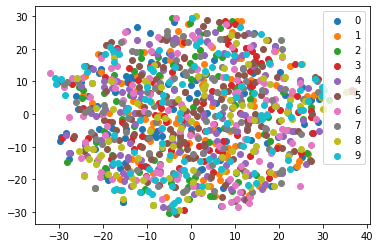

In [ ]:
# an untrained model classifies digits at random!
visualize_predictions(model)

### Train loop

In [ ]:
# Train the model for 10 epochs, iterating on the data in batches
n_epochs = 1

# store metrics
training_accuracy_history = np.zeros([n_epochs, 1])
training_loss_history = np.zeros([n_epochs, 1])
validation_accuracy_history = np.zeros([n_epochs, 1])
validation_loss_history = np.zeros([n_epochs, 1])

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/10:', end='')
    train_total = 0
    train_correct = 0
    # train
    model.train()
    for i, data in enumerate(training_data_loader):
        images, labels = data
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate categorical cross entropy loss
        loss = criterion(output, labels)
        # backward pass
        loss.backward()
        optimizer.step()
        
        # track training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % 180 == 0: print('.',end='')
    training_loss_history[epoch] /= len(training_data_loader)
    training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')
        
    # validate
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_data_loader):
            images, labels = data
            # forward pass
            output = model(images)
            # find accuracy
            _, predicted = torch.max(output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            # find loss
            loss = criterion(output, labels)
            validation_loss_history[epoch] += loss.item()
        validation_loss_history[epoch] /= len(test_data_loader)
        validation_accuracy_history[epoch] = test_correct / test_total
    print(f', val loss: {validation_loss_history[epoch,0]:0.4f}, val acc: {validation_accuracy_history[epoch,0]:0.4f}')

Epoch 1/10:

ValueError: ignored

In [ ]:
def create_model(drop_out, eps):
  model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(3,3)),
    nn.BatchNorm2d(8, eps=eps),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=drop_out),
    
    nn.Conv2d(8, 8, kernel_size=(3,3)),
    nn.BatchNorm2d(8, eps=eps),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=drop_out),
    
    nn.Flatten(),
    nn.Linear(25*8, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
  )
  return model

# Train the model for n_epochs epochs then validates it and prints the loss at each epoch
def perform_model(n_epochs, model, criterion, optimizer, training_data_loader, test_data_loader):
  # store metrics
  training_accuracy_history = np.zeros([n_epochs, 1])
  training_loss_history = np.zeros([n_epochs, 1])
  validation_accuracy_history = np.zeros([n_epochs, 1])
  validation_loss_history = np.zeros([n_epochs, 1])

  for epoch in range(n_epochs):
      print(f'Epoch {epoch+1}/10:', end='')
      train_total = 0
      train_correct = 0
      # train
      model.train()
      for i, data in enumerate(training_data_loader):
          images, labels = data
          optimizer.zero_grad()
          # forward pass
          output = model(images)
          # calculate categorical cross entropy loss
          loss = criterion(output, labels)
          # backward pass
          loss.backward()
          optimizer.step()
          
          # track training accuracy
          _, predicted = torch.max(output.data, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()
          # track training loss
          training_loss_history[epoch] += loss.item()
          # progress update after 180 batches (~1/10 epoch for batch size 32)
          if i % 180 == 0: print('.',end='')
      training_loss_history[epoch] /= len(training_data_loader)
      training_accuracy_history[epoch] = train_correct / train_total
      print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')
          
      # validate
      test_total = 0
      test_correct = 0
      with torch.no_grad():
          model.eval()
          for i, data in enumerate(test_data_loader):
              images, labels = data
              # forward pass
              output = model(images)
              # find accuracy
              _, predicted = torch.max(output.data, 1)
              test_total += labels.size(0)
              test_correct += (predicted == labels).sum().item()
              # find loss
              loss = criterion(output, labels)
              validation_loss_history[epoch] += loss.item()
          validation_loss_history[epoch] /= len(test_data_loader)
          validation_accuracy_history[epoch] = test_correct / test_total
      print(f', val loss: {validation_loss_history[epoch,0]:0.4f}, val acc: {validation_accuracy_history[epoch,0]:0.4f}')

In [ ]:
drop_probs = np.arange(0, 1, 0.1)
epsilons = np.arange(1e-5, 1e-4, 1e-5)
best_epsilon = 0.0005
best_drop = 0.1
models = []

for drop_out in drop_probs:
  print("Testing Drop Out Probability =", drop_out)
  model = create_model(drop_out, best_epsilon)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(model.parameters())
  perform_model(1, model, criterion, optimizer, training_data_loader, test_data_loader)
  models.append(model)

for eps in epsilons:
  print("Testing Batch Epsilon =", eps)
  model = create_model(best_drop, eps)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(model.parameters())
  perform_model(1, model, criterion, optimizer, training_data_loader, test_data_loader)
  models.append(model)

Testing Drop Out Probability = 0.0
Epoch 1/10:...........
	loss: 0.2082, acc: 0.9376, val loss: 0.0949, val acc: 0.9702
Testing Drop Out Probability = 0.1
Epoch 1/10:...........
	loss: 0.2354, acc: 0.9293, val loss: 0.0703, val acc: 0.9784
Testing Drop Out Probability = 0.2
Epoch 1/10:...........
	loss: 0.2915, acc: 0.9095, val loss: 0.0903, val acc: 0.9693
Testing Drop Out Probability = 0.30000000000000004
Epoch 1/10:...........
	loss: 0.4002, acc: 0.8784, val loss: 0.1025, val acc: 0.9670
Testing Drop Out Probability = 0.4
Epoch 1/10:...........
	loss: 0.4082, acc: 0.8757, val loss: 0.1256, val acc: 0.9636
Testing Drop Out Probability = 0.5
Epoch 1/10:...........
	loss: 0.6798, acc: 0.7808, val loss: 0.1834, val acc: 0.9489
Testing Drop Out Probability = 0.6000000000000001
Epoch 1/10:...........
	loss: 0.7279, acc: 0.7621, val loss: 0.2214, val acc: 0.9390
Testing Drop Out Probability = 0.7000000000000001
Epoch 1/10:...........
	loss: 1.0146, acc: 0.6600, val loss: 0.4097, val acc: 0

We can see from the results above that a drop probability of 0.1 and a batch epsilon of 8e-5 yield the greatest validation accuracy. So, lets choose that for our model below.

In [ ]:
best_epsilon = 8e-5
best_drop = 0.1

model = create_model(best_drop, best_epsilon)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())
perform_model(10, model, criterion, optimizer, training_data_loader, test_data_loader)

Epoch 1/10:...........
	loss: 0.2499, acc: 0.9297, val loss: 0.0890, val acc: 0.9709
Epoch 2/10:...........
	loss: 0.1128, acc: 0.9647, val loss: 0.0784, val acc: 0.9743
Epoch 3/10:...........
	loss: 0.0973, acc: 0.9703, val loss: 0.0776, val acc: 0.9771
Epoch 4/10:...........
	loss: 0.0873, acc: 0.9743, val loss: 0.0711, val acc: 0.9774
Epoch 5/10:...........
	loss: 0.0841, acc: 0.9741, val loss: 0.0709, val acc: 0.9772
Epoch 6/10:...........
	loss: 0.0793, acc: 0.9760, val loss: 0.0555, val acc: 0.9821
Epoch 7/10:...........
	loss: 0.0776, acc: 0.9765, val loss: 0.0463, val acc: 0.9856
Epoch 8/10:...........
	loss: 0.0738, acc: 0.9776, val loss: 0.0462, val acc: 0.9859
Epoch 9/10:...........
	loss: 0.0703, acc: 0.9788, val loss: 0.0563, val acc: 0.9840
Epoch 10/10:...........
	loss: 0.0697, acc: 0.9795, val loss: 0.0583, val acc: 0.9837


Our model validation accuracy decreases after epoch 8, so we'll switch the optimizer to the Adam. Let's test that below.

In [ ]:
best_epsilon = 8e-5
best_drop = 0.2

model = create_model(best_drop, best_epsilon)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
perform_model(10, model, criterion, optimizer, training_data_loader, test_data_loader)

Epoch 1/10:...........
	loss: 0.2964, acc: 0.9081, val loss: 0.0733, val acc: 0.9776
Epoch 2/10:...........
	loss: 0.1248, acc: 0.9604, val loss: 0.0486, val acc: 0.9839
Epoch 3/10:...........
	loss: 0.1000, acc: 0.9678, val loss: 0.0414, val acc: 0.9870
Epoch 4/10:...........
	loss: 0.0856, acc: 0.9727, val loss: 0.0399, val acc: 0.9883
Epoch 5/10:...........
	loss: 0.0795, acc: 0.9749, val loss: 0.0342, val acc: 0.9886
Epoch 6/10:...........
	loss: 0.0730, acc: 0.9771, val loss: 0.0401, val acc: 0.9881
Epoch 7/10:...........
	loss: 0.0683, acc: 0.9787, val loss: 0.0329, val acc: 0.9896
Epoch 8/10:...........
	loss: 0.0648, acc: 0.9793, val loss: 0.0316, val acc: 0.9901
Epoch 9/10:...........
	loss: 0.0664, acc: 0.9785, val loss: 0.0313, val acc: 0.9897
Epoch 10/10:...........
	loss: 0.0602, acc: 0.9804, val loss: 0.0321, val acc: 0.9898


It works! Validation Accuracy of the final model is = 0.9898 > 0.985, so we'll stop here.

### Trained model visualization

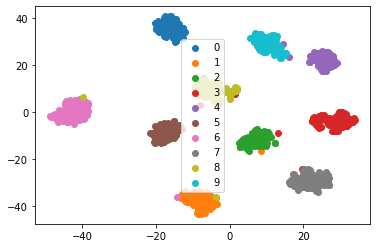

In [ ]:
# A trained model should be able to group input images by digit!
visualize_predictions(model)

Now, let's find those 10 dop out probability ranged models!

In [ ]:
drop_probs = np.arange(0, 1, 0.1)
best_epsilon = 8e-5
models = []

for drop_out in drop_probs:
  print("Testing Drop Out Probability =", drop_out)
  model = create_model(drop_out, best_epsilon)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(model.parameters())
  perform_model(1, model, criterion, optimizer, training_data_loader, test_data_loader)

Testing Drop Out Probability = 0.0
Epoch 1/10:...........
	loss: 0.1996, acc: 0.9422, val loss: 0.1068, val acc: 0.9665
Testing Drop Out Probability = 0.1
Epoch 1/10:...........
	loss: 0.2813, acc: 0.9184, val loss: 0.0860, val acc: 0.9733
Testing Drop Out Probability = 0.2
Epoch 1/10:...........
	loss: 0.3142, acc: 0.9068, val loss: 0.1105, val acc: 0.9634
Testing Drop Out Probability = 0.30000000000000004
Epoch 1/10:...........
	loss: 0.3757, acc: 0.8843, val loss: 0.1061, val acc: 0.9696
Testing Drop Out Probability = 0.4
Epoch 1/10:...........
	loss: 0.4400, acc: 0.8621, val loss: 0.1399, val acc: 0.9592
Testing Drop Out Probability = 0.5
Epoch 1/10:...........
	loss: 0.5289, acc: 0.8346, val loss: 0.1980, val acc: 0.9393
Testing Drop Out Probability = 0.6000000000000001
Epoch 1/10:...........
	loss: 0.6450, acc: 0.7960, val loss: 0.2140, val acc: 0.9468
Testing Drop Out Probability = 0.7000000000000001
Epoch 1/10:...........
	loss: 0.8212, acc: 0.7304, val loss: 0.2746, val acc: 0